# CII VID Forecast Notebook

This notebook contains a ready-to-run template to forecast the Voxel Intensity Distribution (VID) for a CII line-intensity-mapping survey.

**What it does:**
- Builds a Schechter luminosity function
- Maps luminosity -> voxel intensity (placeholder conversion)
- Computes the single-source intensity PDF p1(I)
- Computes the compound-Poisson VID via FFT
- Convolves with instrumental noise
- Bins intensities and computes expected voxel counts
- Produces a Fisher forecast for Schechter parameters


> **Notes:** Replace the placeholder `L_to_I` conversion with a real cosmological conversion for physical units, and supply realistic survey parameters for a genuine forecast.

Run the code cells below to execute the pipeline.


Expected mean count per voxel Nbar = 0.0487

Fiducial parameters:
  phi_star = 0.001
  L_star = 1.0
  alpha = -1.3

Forecast 1-sigma errors (Fisher approx):
  sigma(phi_star) = 2.404e-03
  sigma(L_star) = 1.469e+00
  sigma(alpha) = 2.589e+00


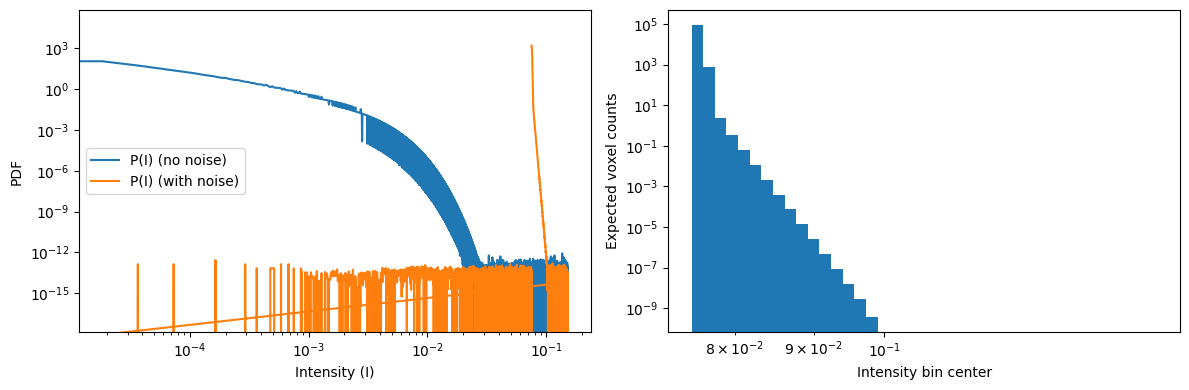

In [ ]:
# CII_VID_Forecast_Notebook - notebook cell
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftshift, ifftshift
from scipy.interpolate import interp1d
from scipy.special import gamma
import copy

def schechter_L(L, phi_star, L_star, alpha):
    return phi_star * (L / L_star)**alpha * np.exp(-L / L_star) / L_star

def L_to_I(L, z, delta_nu, conv_mode='I_nu'):
    conv = 1e-3
    return conv * L

def build_p1_I(Lgrid, phi_L, V_vox, Imin, Imax, nI):
    Igrid_fromL = Lgrid.copy()
    Ireg = np.linspace(Imin, Imax, nI)
    dI = Ireg[1] - Ireg[0]
    p1_counts = np.zeros_like(Ireg)
    dL = np.diff(Lgrid)
    dL = np.append(dL, dL[-1])
    for Li, phiLi, dl in zip(Igrid_fromL, phi_L, dL):
        idx = int(np.clip((Li - Imin) // dI, 0, len(Ireg)-1))
        p1_counts[idx] += (V_vox * phiLi) * dl
    Nbar = np.sum(p1_counts)
    if Nbar <= 0:
        raise ValueError('Nbar <= 0, check phi_L or V_vox')
    p1_I = p1_counts / (Nbar * dI)
    return Ireg, p1_I, Nbar

def compound_poisson_pdf_from_p1(Ireg, p1_I, Nbar):
    dI = Ireg[1] - Ireg[0]
    p1_hat = fft(p1_I) * dI
    P_hat = np.exp(Nbar * (p1_hat - 1.0))
    P_I = np.real(ifft(P_hat)) / dI
    P_I = fftshift(P_I)
    Ireg_shifted = fftshift(Ireg - Ireg[0])
    P_I[P_I < 0] = 0.0
    norm = np.sum(P_I) * dI
    if norm > 0:
        P_I = P_I / norm
    return Ireg_shifted, P_I

def convolve_with_gaussian(Ireg, P_I, sigma_noise):
    dI = Ireg[1] - Ireg[0]
    kernel = np.exp(-0.5 * (Ireg - 0.0)**2 / sigma_noise**2)
    kernel = kernel / (np.sum(kernel) * dI)
    P_I_noisy = np.real(ifft(fft(P_I) * fft(kernel)))
    P_I_noisy[P_I_noisy < 0] = 0.0
    norm = np.sum(P_I_noisy) * dI
    if norm > 0:
        P_I_noisy = P_I_noisy / norm
    return P_I_noisy

def compute_binned_counts(Ireg, P_I, Nvox, bin_edges):
    cdf = np.cumsum(P_I) * (Ireg[1] - Ireg[0])
    f_interp = interp1d(Ireg, cdf, bounds_error=False, fill_value=(0.0,1.0))
    lambdas = []
    for a,b in zip(bin_edges[:-1], bin_edges[1:]):
        prob = f_interp(b) - f_interp(a)
        lambdas.append(Nvox * prob)
    return np.array(lambdas)

def fisher_from_binned_counts(lambda_b, dlam_dtheta):
    nbins = len(lambda_b)
    npars = dlam_dtheta.shape[0]
    F = np.zeros((npars, npars))
    for b in range(nbins):
        lb = lambda_b[b]
        if lb <= 0:
            continue
        grad = dlam_dtheta[:, b]
        F += np.outer(grad, grad) / lb
    return F

def numeric_derivatives(params, param_keys, build_lambda_fn, eps_frac=1e-2):
    base_lambda = build_lambda_fn(params)
    npars = len(param_keys)
    nbins = len(base_lambda)
    dlam = np.zeros((npars, nbins))
    for i, key in enumerate(param_keys):
        p0 = params[key]
        dp = max(abs(p0) * eps_frac, 1e-8)
        params_hi = copy.deepcopy(params)
        params_lo = copy.deepcopy(params)
        params_hi[key] = p0 + dp
        params_lo[key] = p0 - dp
        lam_hi = build_lambda_fn(params_hi)
        lam_lo = build_lambda_fn(params_lo)
        dlam[i, :] = (lam_hi - lam_lo) / (2.0 * dp)
    return base_lambda, dlam




NameError: name 'Ireg_shifted' is not defined

Expected mean count per voxel Nbar = 0.0487

Fiducial parameters:
  phi_star = 0.001
  L_star = 1.0
  alpha = -1.3

Forecast 1-sigma errors (Fisher approx):
  sigma(phi_star) = 2.404e-03
  sigma(L_star) = 1.469e+00
  sigma(alpha) = 2.589e+00


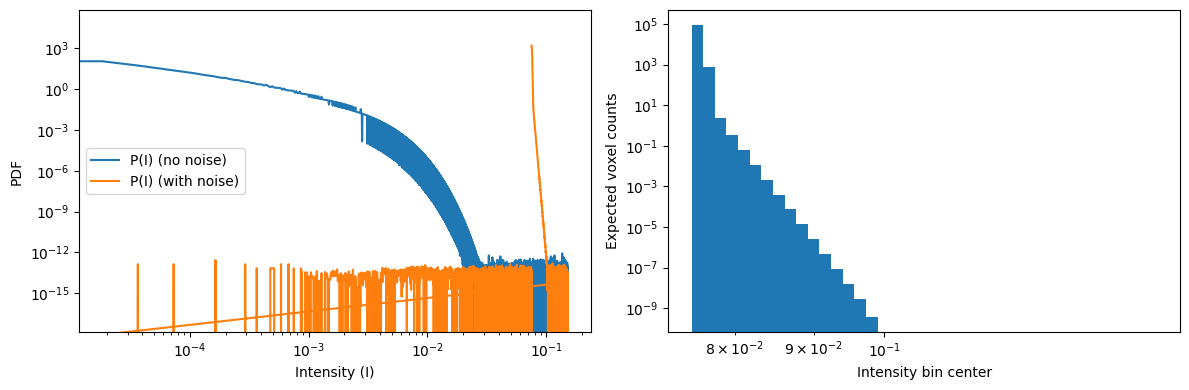

In [5]:

params = {
    'phi_star': 1e-3,
    'L_star': 1.0,
    'alpha': -1.3
}
z = 6.0
V_vox = 1e3
Nvox = int(1e5)
sigma_noise = 5e-4
Lmin, Lmax = 1e-4, 50.0
nL = 2000
Lgrid = np.logspace(np.log10(Lmin), np.log10(Lmax), nL)
phi_L = schechter_L(Lgrid, params['phi_star'], params['L_star'], params['alpha'])
I_fromL = L_to_I(Lgrid, z, delta_nu=1.0)
Imin, Imax = 0.0, float(I_fromL.max() * 3.0)
nI = 2**13
Ireg, p1_I, Nbar = build_p1_I(I_fromL, phi_L, V_vox, Imin, Imax, nI)
print(f"Expected mean count per voxel Nbar = {Nbar:.4f}")
Ireg_shifted, P_I = compound_poisson_pdf_from_p1(Ireg, p1_I, Nbar)
P_I_noisy = convolve_with_gaussian(Ireg_shifted, P_I, sigma_noise)
nbins = 40
bin_edges = np.logspace(np.log10(max(1e-10, Ireg_shifted[1])), np.log10(Ireg_shifted.max()), nbins+1)
def build_lambda_b(local_params):
    phi_L_local = schechter_L(Lgrid, local_params['phi_star'], local_params['L_star'], local_params['alpha'])
    Ireg_loc, p1_I_loc, Nbar_loc = build_p1_I(I_fromL, phi_L_local, V_vox, Imin, Imax, nI)
    Ireg_loc_s, P_I_loc = compound_poisson_pdf_from_p1(Ireg_loc, p1_I_loc, Nbar_loc)
    P_I_loc_noisy = convolve_with_gaussian(Ireg_loc_s, P_I_loc, sigma_noise)
    lambda_b = compute_binned_counts(Ireg_loc_s, P_I_loc_noisy, Nvox, bin_edges)
    return lambda_b
param_keys = ['phi_star', 'L_star', 'alpha']
base_lambda, dlam = numeric_derivatives(params, param_keys, build_lambda_b, eps_frac=1e-2)
F = fisher_from_binned_counts(base_lambda, dlam)
try:
    cov = np.linalg.inv(F)
except np.linalg.LinAlgError:
    reg = 1e-12 * np.eye(F.shape[0])
    cov = np.linalg.inv(F + reg)
errs = np.sqrt(np.diag(cov))
print('\nFiducial parameters:')
for k in param_keys:
    print(f"  {k} = {params[k]}")
print('\nForecast 1-sigma errors (Fisher approx):')
for k, e in zip(param_keys, errs):
    print(f"  sigma({k}) = {e:.3e}")
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(Ireg_shifted, P_I, label='P(I) (no noise)')
axs[0].plot(Ireg_shifted, P_I_noisy, label='P(I) (with noise)')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('Intensity (I)')
axs[0].set_ylabel('PDF')
axs[0].legend()
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
axs[1].bar(bin_centers, base_lambda, width=bin_edges[1:]-bin_edges[:-1])
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('Intensity bin center')
axs[1].set_ylabel('Expected voxel counts')
plt.tight_layout()
plt.show()


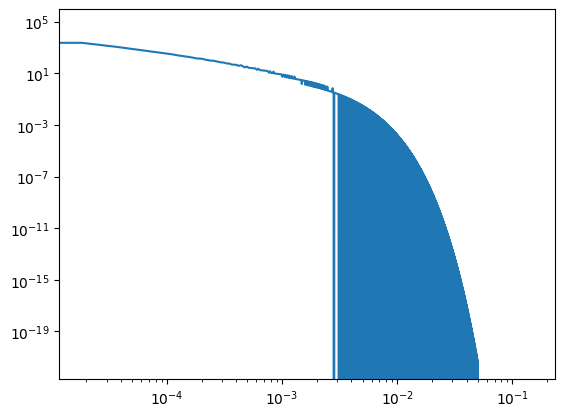

In [ ]:
plt.loglog(Ireg, p1_I,)